In [1]:
import warnings  
warnings.filterwarnings('ignore')

# basics
import pandas as pd
import numpy as np
import math

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import itertools

# regression
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from scipy.stats import f_oneway
from scipy import stats
from statsmodels.compat import lzip

# other prediction methods
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB


# evalutiation
import statsmodels.tools.eval_measures as smem
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV

C:\Users\Tabea\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
cRange = ['#475468', '#e7e6e6', '#4b73be', '#df8244', '#a5a5a5', '#f7c143',
          '#20406a', '#deeef8', '#2d6fc0', '#409cd4', '#5ccdd7', '#5ecb9e',
          '#a53218', '#c59933', '#f08a40', '#aa4f30', '#f7bf5d', '#d85733',
          '#728083', '#8babb4', '#7196ad', '#607397', '#8585c2', '#a687c1']
colors = ['#475468', '#e7e6e6', '#4b73be', 
          '#df8244', '#a5a5a5', '#f7c143'] 
cmapOffice = mpl.colors.ListedColormap([cRange[i] for i in range(0, 5)])
cmapBlue = mpl.colors.ListedColormap([cRange[i] for i in range(6, 11)])
cmapRed = mpl.colors.ListedColormap([cRange[i] for i in range(12, 17)])
cmapViolett = mpl.colors.ListedColormap([cRange[i] for i in range(18, 23)])

In [3]:
df = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
df.index = pd.to_datetime(df.index)


# add hourly moving avg total
df["hourly_moving_avg_2"] = df["hourly_moving_avg_2_solar"] + df["hourly_moving_avg_2_wind"]
df["hourly_moving_avg"] = df["hourly_moving_avg_solar"] + df["hourly_moving_avg_solar"]
df["hourly_moving_avg_7"] = df["hourly_moving_avg_7_solar"] + df["hourly_moving_avg_7_wind"]

# Shift moving averages because values are not known at time of prediction
dropCols = list()
for c in df.columns:
    if "wind" in c or "solar" in c:
        dropCols.append(c)
    elif "avg" in c or "max" in c:
        dropCols.append(c)
        df[c+"_shifted"] = df[c].shift(24)
        df.loc["2016-01-01 00:00:00":"2016-01-01 23:00:00", c+"_shifted"] = 0 # to avoid NaN value

data = df[["price_diff", "hour", "season", "month", "weekday", "total_generation_forecast", "forecast_error", "day_ahead_price", "intraday_price"]]

## Feature selection

Index(['hour', 'total_generation_forecast', 'forecast_error', 'season',
       'month', 'weekday', 'mov_avg_30_forecast_error_shifted',
       'mov_avg_10_forecast_error_shifted', 'mov_avg_1_forecast_error_shifted',
       'mov_avg_1_day_ahead_shifted', 'mov_avg_1_intraday_shifted',
       'hourly_moving_avg_2_shifted', 'hourly_moving_avg_shifted',
       'hourly_moving_avg_7_shifted'],
      dtype='object')
       hour  total_generation_forecast  forecast_error  season  month  \
0         0                       6033            2615       0      1   
1         1                       7421            1158       0      1   
2         2                       7266            1276       0      1   
3         3                       7180            1263       0      1   
4         4                       7016            1279       0      1   
5         5                       6787             532       0      1   
6         6                       6492              82       0      1   
7   

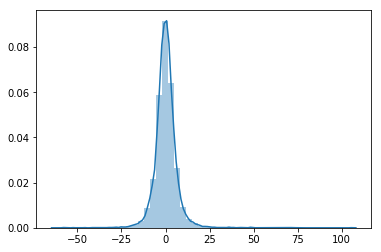

In [4]:
X_pd = df.drop(dropCols+    # moving averages not known at prediction time => use shifted columns
            [
            # not known:
                "day_ahead_price",
                "intraday_price",
                "price_diff",
                "total_generation_actual"
                 ], axis=1)
X_pd = X_pd.reset_index()
X_pd = X_pd.drop("datetime", axis=1)
seasons = ["winter", "spring", "summer", "fall"]
#X_pd["season"] = X_pd["season"].apply(lambda x: seasons[x])
#X_pd[["hour", "weekday","month"]].astype('str')
print(X_pd.columns)
y_pd_val = pd.DataFrame(df["price_diff"], index=df.index)

# find distribution of price diff values to build classes
sns.distplot(y_pd_val)

def convertToClasses(y, classNum):
    values = range(0, classNum)
    if classNum==4:
        y2 = y.applymap(lambda y: values[[(y<-3), ((-3<=y) & (y<0)), ((0<=y) & (y<3)), y>=3].index(True)])
    else:
        y2 = y.applymap(lambda y: values[[y < 0, y >= 0].index(True)])
    return y2


y_pd = convertToClasses(y_pd_val, 2)

# Create a holdout set for later testing of the methods. Try to predict class positive/negative for positive or negative price_diff
X, X_holdout, y, y_holdout = train_test_split(X_pd, y_pd);

y_holdout_val = y_pd_val.loc[y_holdout.index.values]
print(X_pd)

### Evaluation metrics

In [5]:
# Find costs for misclassification
print("Mean price differences for the different heights of price differences")
print(df[df.price_diff<-3].price_diff.mean())
print(df[(df.price_diff>-3) & (df.price_diff<=0)].price_diff.mean())
print(df[(df.price_diff>0) & (df.price_diff<3)].price_diff.mean())
print(df[df.price_diff>=3].price_diff.mean())

Mean price differences for the different heights of price differences
-6.944230222643307
-1.437647320435845
1.4159768064228389
7.505088935088937


In [6]:
numberOfRuns = 1 # 10 times cross-validaton

def custom_loss_func(y_true, y_pred):
    y2 = convertToClasses(y_true,4)
    y2 = np.concatenate((y2["price_diff"].values.reshape(len(y2), 1), y_pred.reshape(len(y_pred), 1)), axis=1)
    # y2 = y_true | y_pred
    criteria = [((y2[:,1]==0) & (y2[:,0]==2)) | ((y2[:,1] == 1) & (y2[:,0] == 1)), 
                ((y2[:,1]==0) & (y2[:,0]==3)) | ((y2[:,1] == 1) & (y2[:,0] == 0))]
    values = [1.4, 7]
    cost = np.select(criteria, values, 0)
    return cost.sum()

# Dict containing the scorers to be used for classification
scoring = {'accuracy': 'accuracy',
            'precision': 'precision',
              'recall':'recall'#,
              #'cost':  make_scorer(custom_loss_func, greater_is_better=False)
          }

# Function to convert the list of dicts to a DataFrame and then print it for classification scores
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=[list(range(numberOfRuns))*len(param_range), list(param_range)*numberOfRuns]).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["accuracy", #"cost",
                       "precision", # fraction of actual price increases in predicted price increases
                       "recall"]    # fraction of price increases that are identified as such
    scores_df = scores_df.groupby(level=1).mean()
    display(scores_df)
    
# function to build a cross-validated confusion matrix
def makeConfusionMatrix(model):
    unifiedCM = np.zeros([2,2])
    kf = KFold(n_splits=3)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        cm = confusion_matrix(y_test, model.predict(X_test))
        unifiedCM = unifiedCM+cm

    return (unifiedCM / unifiedCM.sum()).round(2)


## Try different prediction methods

In [7]:
# Method: Regression
def prepareDataForRegression(X):
    dummies = pd.get_dummies(X["season"]).iloc[:,:-1]
    seasons = ["winter", "spring", "summer"]
    dummies.columns = dummies.columns.map(lambda x: seasons[x])
    X2 = X.drop(columns=["season", "hour"], axis=1)
    X2 = X2.join(dummies)
    X2.forecast_error.astype('float')
    X2.total_generation_forecast.astype('float')
    return X2

In [8]:
def plotGridResults(results, paramName):
    plt.figure(figsize=(5, 5))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

    plt.xlabel(paramName)
    plt.ylabel("Score")

    ax = plt.gca()
    #ax.set_xlim(0, 402)
    ax.set_ylim(0.5, 0.9)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_'+paramName].data, dtype=float)

    for scorer, color in zip(sorted(scoring), colors):
        print(scorer)
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid('off')
    plt.show()

{'C': 0.01}
accuracy
precision
recall


C:\Users\Tabea\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


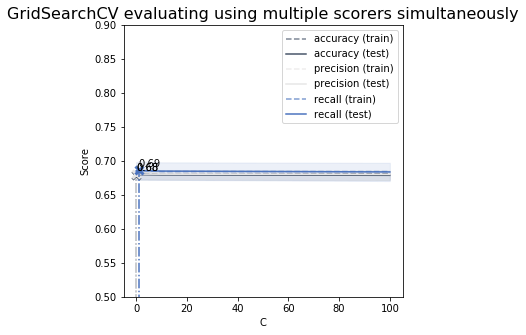

In [9]:
grid = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), 
                    param_grid={'C': [0.001,0.01,0.1,1,10,100]}, scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)
grid.fit(X, y.values.reshape(1,len(y))[0])
results = grid.cv_results_
best_plist = grid.best_params_
print(best_plist)
plotGridResults(results, "C")

{'max_depth': 23, 'min_samples_leaf': 1, 'min_samples_split': 2}
accuracy
precision
recall


C:\Users\Tabea\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


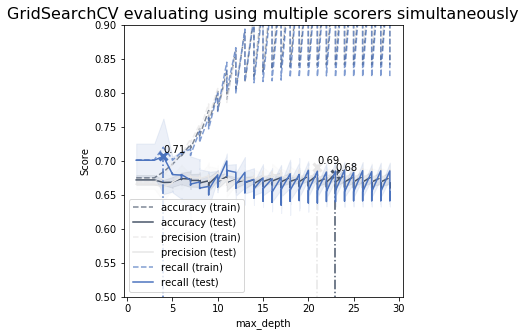

accuracy
precision
recall


C:\Users\Tabea\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


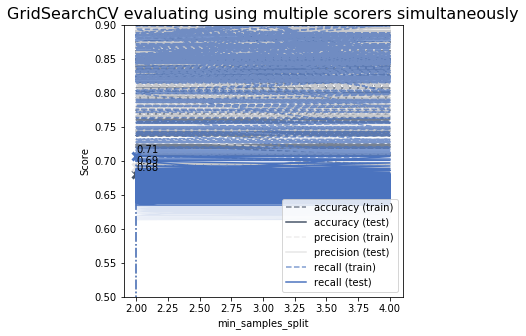

In [10]:
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                    param_grid={'max_depth': range(1, 30), 
                                'min_samples_split': range(2, 5), 
                                'min_samples_leaf': range(1,10)}, 
                    scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)
grid.fit(X, y.values.reshape(1,len(y))[0])
results = grid.cv_results_
best_plist = grid.best_params_
print(best_plist)
plotGridResults(results, 'max_depth')
plotGridResults(results, 'min_samples_split')

accuracy
precision
recall


C:\Users\Tabea\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


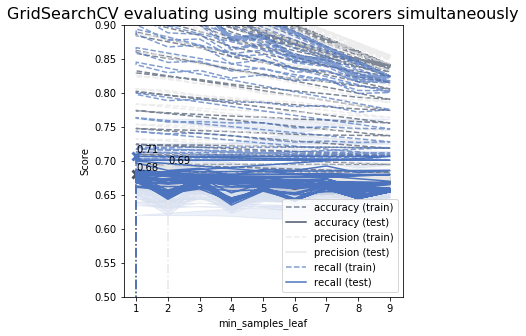

In [11]:
plotGridResults(results, 'min_samples_leaf')

In [12]:
# Method: Decision Tree Classfier
param_range = range(2,20)
scores_list = []
for j in range(numberOfRuns):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    X2 = prepareDataForRegression(X_train)
    for i in param_range:
        DTC = DecisionTreeClassifier(max_depth=i, min_samples_leaf= 4, min_samples_split= 2)
        scores_list.append(cross_validate(DTC, X_train, y_train, scoring=scoring, return_train_score=False, n_jobs=-1))
display(print_scores(scores_list, param_range))

,accuracy,precision,recall
2,0.675280,0.671219,0.696959
3,0.673659,0.666628,0.705604
4,0.670821,0.671375,0.679870
5,0.674571,0.683943,0.664773
6,0.676294,0.677369,0.685892
7,0.674065,0.680365,0.669000
8,0.672140,0.688996,0.639244
9,0.671432,0.691567,0.628392
10,0.664945,0.676515,0.643077
11,0.661601,0.667762,0.655739


None

In [13]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), 
                    param_grid={'max_depth': range(10, 30), 
                                'n_estimators': [10, 20, 50],
                                'min_samples_split': range(2, 5), 
                                'min_samples_leaf': range(1,10)}, 
                    scoring=scoring, refit='accuracy', return_train_score=True, n_jobs=-1)
grid.fit(X, y.values.reshape(1,len(y))[0])
results = grid.cv_results_
best_plist = grid.best_params_
print(best_plist)


{'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


accuracy
precision
recall


C:\Users\Tabea\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


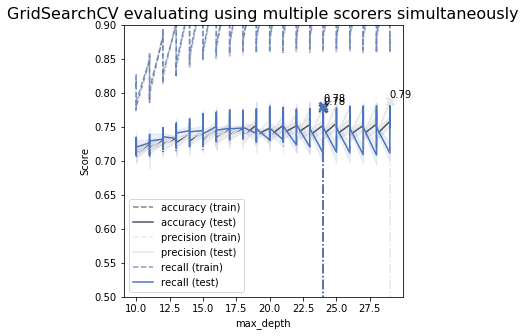

KeyError: 'param_max_features'

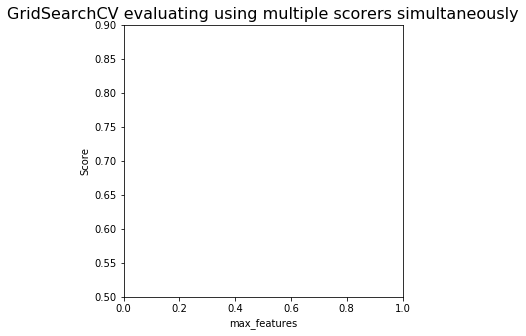

In [14]:
plotGridResults(results, 'max_depth')
plotGridResults(results, 'max_features')

In [15]:
# Method: Random Forest Classifier
param_range = range(1,15)
scores_list = []
for j in range(numberOfRuns):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    for i in param_range:
        RTC = RandomForestClassifier(max_features=i)
        scores_list.append(cross_validate(RTC, X_train, y_train, scoring=scoring, return_train_score=False, n_jobs=-1))
display(print_scores(scores_list, param_range))

,accuracy,precision,recall
1,0.729705,0.762094,0.675502
2,0.737914,0.768047,0.688755
3,0.728692,0.755399,0.683936
4,0.725347,0.752823,0.678715
5,0.723320,0.750336,0.677309
6,0.721496,0.747121,0.677510
7,0.719368,0.745003,0.675301
8,0.722611,0.745751,0.683333
9,0.718557,0.746480,0.669880
10,0.721395,0.748224,0.675502


None

C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


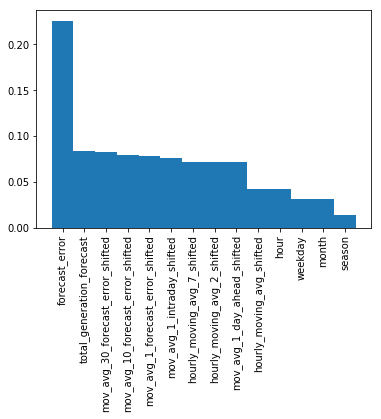

[(0.2259, 'forecast_error'),
 (0.0834, 'total_generation_forecast'),
 (0.0822, 'mov_avg_30_forecast_error_shifted'),
 (0.0788, 'mov_avg_10_forecast_error_shifted'),
 (0.0787, 'mov_avg_1_forecast_error_shifted'),
 (0.0756, 'mov_avg_1_intraday_shifted'),
 (0.072, 'hourly_moving_avg_7_shifted'),
 (0.072, 'hourly_moving_avg_2_shifted')]

In [16]:
# See how important the features of the data frame are for the prediction with Random Forests

RFC = RandomForestClassifier(max_depth=30, max_features=5, min_samples_leaf=1, min_samples_split=2)
RFC.fit(X,y)
features = sorted(zip(map(lambda x: round(x, 4), RFC.feature_importances_), X.columns), reverse=True)
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels, rotation='vertical')
plt.show()
features[0:8]

In [20]:
# Method: Naive Bayes
scores_list = []
param_range = range(2)
for j in range(numberOfRuns):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    X2 = prepareDataForRegression(X_train)
    for i in param_range:
        nb = GaussianNB()
        scores_list.append(cross_validate(nb, X_train, y_train, scoring=scoring, return_train_score=False, n_jobs=-1))
print_scores(scores_list, param_range)

,accuracy,precision,recall
0,0.669808,0.663274,0.701107
1,0.669808,0.663274,0.701107


## Evaluation

Final evaluation of classifiers with holdout set

In [21]:
# plot confusion matrix
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    

    y_true = convertToClasses(y_true, 4)
    y = np.concatenate((y_true["price_diff"].values.reshape(len(y_true), 1), y_pred.reshape(len(y_pred), 1)), axis=1)

    cm = np.zeros([4,2])
    for i in range(4):
        for j in range(2):
            cm[i,j] = ((y[:,0]==i) & (y[:,1]==j)).sum()

            
    if normalize:
        cm = cm.astype('float') / cm.sum()
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    colors = [['#475468', '#a53218'],['#e7e6e6', '#c59933'],['#f08a40', '#4b73be'],['#aa4f30', '#df8244']]
    
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(2)
    y_tick_marks = np.arange(4)
    plt.xticks(x_tick_marks, ["Intraday", "Day ahead"], rotation=45)
    plt.yticks(y_tick_marks, ["ID cheaper (++)", "ID cheaper (+)", "DA cheaper (+)", "DA cheaper (++)"])

    fmt = '.2f' #if normalize else 'd'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True choice')
    plt.xlabel('Market choice')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return cm

No handles with labels found to put in legend.


Normalized confusion matrix


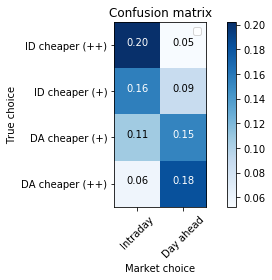

Sum of diagonal: [0.35499316]


C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':
No handles with labels found to put in legend.


Normalized confusion matrix


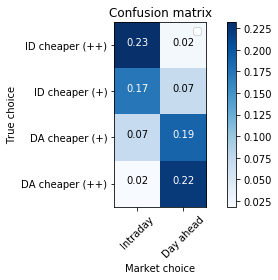

Sum of diagonal: [0.42042864]


C:\Users\Tabea\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


Normalized confusion matrix


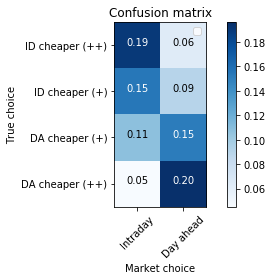

C:\Users\Tabea\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
No handles with labels found to put in legend.


Sum of diagonal [0.34222526]
Normalized confusion matrix


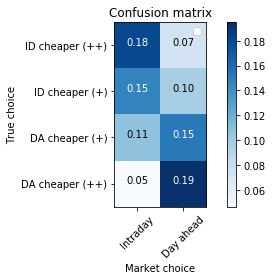

Sum of diagonal: [0.33310534]


,Accuracy,Cost
RFC,0.816917,2126.6
DTC,0.693798,4613
logReg,0.692886,4562.6
NB,0.674875,4953.2


In [22]:
results = pd.DataFrame(index=["DTC", "RFC", "logReg", "NB"], columns=["Accuracy", "Cost"])

DTC = DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=2)
model = DTC.fit(X, y)
y_pred = model.predict(X_holdout)
results.loc["DTC", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["DTC", "Cost"] = custom_loss_func(y_holdout_val, y_pred)
cm = plot_confusion_matrix(y_holdout_val, y_pred, normalize=True)
print("Sum of diagonal:", cm[0:1,0]+cm[2:3,1])

RFC = RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
model = RFC.fit(X, y)
y_pred = model.predict(X_holdout)
results.loc["RFC", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["RFC", "Cost"] = custom_loss_func(y_holdout_val, y_pred)
cm = plot_confusion_matrix(y_holdout_val, y_pred, normalize=True)
print("Sum of diagonal:",cm[0:1,0]+cm[2:3,1])

logReg = linear_model.LogisticRegression(C=0.01)
logReg.fit(X, y)
y_pred = logReg.predict(X_holdout)
results.loc["logReg", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["logReg", "Cost"] = custom_loss_func(y_holdout_val, y_pred)
cm = plot_confusion_matrix(y_holdout_val, y_pred, normalize=True)
print("Sum of diagonal", cm[0:1,0]+cm[2:3,1])

nb = GaussianNB()
nb.fit(X, y)
y_pred = nb.predict(X_holdout)
results.loc["NB", "Accuracy"] = accuracy_score(y_holdout, y_pred)
results.loc["NB", "Cost"] = custom_loss_func(y_holdout_val, y_pred)
cm = plot_confusion_matrix(y_holdout_val, y_pred, normalize=True)
print("Sum of diagonal:", cm[0:1,0]+cm[2:3,1])

display(results.sort_values("Accuracy", ascending=False))

## Simulation of strategies

In [23]:
def getCostsForDayAhead(data):
    return data.day_ahead_price.sum(axis=0)

def getCostsForIntraday(data):
    return data.intraday_price.sum(axis=0)

def getCostsForRandom(data):
    permutation = np.random.permutation(len(data))
    ind = permutation[:int(len(permutation)*0.5)]
    indIntraday = permutation[int(len(permutation)*0.5):]
    dayAhead = data.iloc[ind,:]
    intraday = data.iloc[indIntraday,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForCondProb(data):
    condProb = 0.66  # from other notebook
    pred = data["forecast_error"]
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_forecast_error"]
    pred.index = data.index
    merged = data_test.join(pred)
    intradayIndices = merged.loc[merged.pred_forecast_error<0,:].sample(frac=condProb).index.values
    dayAheadIndices = list(set(merged.index.values) - set(intradayIndices))
    intraday = merged.loc[intradayIndices]
    dayAhead = merged.loc[dayAheadIndices]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForRandomForest(X_train, y_train, X_test, data_test):
    RFC = RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
    RFC.fit(X_train, y_train)
    pred = RFC.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data_test.index
    merged = data_test.join(pred)
    intraday = merged.loc[merged.pred_price_diff==0,:]
    dayAhead = merged.loc[merged.pred_price_diff==1,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForDecisionTree(X_train, y_train, X_test, data_test):
    DTC = DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=2)
    DTC.fit(X_train, y_train)
    pred = DTC.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data_test.index
    merged = data_test.join(pred)
    intraday = merged.loc[merged.pred_price_diff==0,:]
    dayAhead = merged.loc[merged.pred_price_diff==1,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))



In [24]:
# prepare data for solar forecast error prediction
y_sfe = df.solar_forecast_error

dropCols = list()
for c in df.columns:
    if ("wind" in c) | ("total" in c):
        dropCols.append(c)
        
for c in df.columns:
    if ("avg" in c or "max" in c) & ("shifted" not in c):
        dropCols.append(c)

X_sfe = df.drop(dropCols+    # moving averages not known at prediction time => use shifted columns
            [
             # What we want to predict
             "solar_forecast_error",
             "forecast_error",
    
             # Not known then
             "solar_generation_actual",
             "day_ahead_price",
             "intraday_price",
             "price_diff",
             "solar_24h_max"
            ], axis=1)
X_sfe = X_sfe.reset_index()
X_sfe = X_sfe.drop("datetime", axis=1)
  
# prepare data for wind forecast error prediction
y_wfe = df.wind_forecast_error

dropCols = list()
for c in df.columns:
    if ("solar" in c) | ("total" in c):
        dropCols.append(c)
        
for c in df.columns:
    if ("avg" in c or "max" in c) & ("shifted" not in c):
        dropCols.append(c)

X_wfe = df.drop(dropCols+    # moving averages not known at prediction time => use shifted columns
            [
             # What we want to predict
             "wind_forecast_error",
             "forecast_error",
    
             # Not known then
             "wind_generation_actual",
             "day_ahead_price",
             "intraday_price",
             "price_diff",
             
             "wind_24h_max"
            ], axis=1)
X_wfe = X_wfe.reset_index()
X_wfe = X_wfe.drop("datetime", axis=1)

# use predicted forecast error for price diff prediction
def predictSolarForecastError(X_train, X_test):

    X_train = X_sfe.iloc[X_train.index.values]
    X_test = X_sfe.iloc[X_test.index.values]
    y_train = y_sfe.iloc[X_train.index.values]
    y_test = y_sfe.iloc[X_test.index.values]

    RFR = RandomForestRegressor(max_depth=27, 
                                n_estimators = 50, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                max_features='auto', 
                                n_jobs=-1)
    RFR.fit(X_train, y_train)
    y_pred = RFR.predict(X_test)
    return y_pred

def predictWindForecastError(X_train, X_test):
        
    X_train = X_wfe.iloc[X_train.index.values]
    X_test = X_wfe.iloc[X_test.index.values]
    y_train = y_wfe.iloc[X_train.index.values]
    y_test = y_wfe.iloc[X_test.index.values]

    RFR = RandomForestRegressor(max_depth=29, 
                                n_estimators = 50, 
                                min_samples_split=2, 
                                min_samples_leaf=1, 
                                max_features='auto',
                                n_jobs=-1)
    RFR.fit(X_train, y_train)
    y_pred = RFR.predict(X_test)
    return y_pred

In [25]:
X_train, X_test, y_train2, y_test2 = train_test_split(X_pd, y_pd_val)
y_train = convertToClasses(y_train2, 2)
y_test = convertToClasses(y_test2, 2)
y_pred = predictSolarForecastError(X_train, X_test) + predictWindForecastError(X_train, X_test)
X_test["forecast_error"] = y_pred

RFC = RandomForestClassifier(max_depth=28, n_estimators=50, min_samples_leaf=1, min_samples_split=2, n_jobs=-1)
RFC.fit(X_train, y_train)
y_pred = RFC.predict(X_test)

C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.7950296397628819


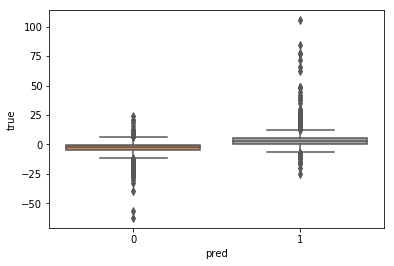

No handles with labels found to put in legend.


Confusion matrix, without normalization


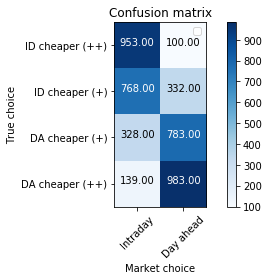

No handles with labels found to put in legend.


Normalized confusion matrix


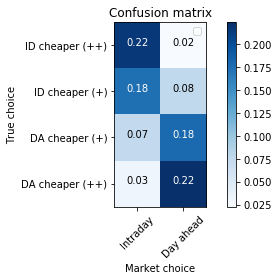

2597.0
8972.599999999999


In [26]:
print(accuracy_score(y_test, y_pred))
plt.figure()
a = pd.DataFrame(y_pred)
b = pd.DataFrame(y_test2)
b.reset_index(inplace=True, drop=True)
c = pd.concat([a,b], axis=1, ignore_index=True)
c.columns = ["pred", "true"]

sns.boxplot(x='pred', y='true', data=c, palette=colors[3:5])
plt.show()

plot_confusion_matrix(y_test2, y_pred)
plot_confusion_matrix(y_test2, y_pred, normalize=True)
print(custom_loss_func(y_test2, y_pred))
print(custom_loss_func(y_test2, np.random.randint(2, size=len(y_pred))))

### Simulation of decision strategies

C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vec

C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vec

C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DataConversionWarning: A column-vec

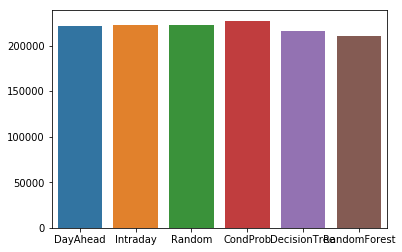

In [27]:
methods = ["DayAhead", "Intraday", "Random", "CondProb", "DecisionTree", "RandomForest"]
methodResults = pd.DataFrame(columns=methods)
for n in range(100):
    X_train, X_test, y_train, y_test  = train_test_split(X_pd, y_pd, test_size=0.4)
    X_test["forecast_error"] = predictSolarForecastError(X_train, X_test) + predictWindForecastError(X_train, X_test)
    y2_train = (y_train>=0).astype('int')
    y2_test = (y_test>=0).astype('int')
    data_test = data.iloc[X_test.index.values]
    res = []
    res.append(getCostsForDayAhead(data_test))
    res.append(getCostsForIntraday(data_test))
    res.append(getCostsForRandom(data_test))
    res.append(getCostsForCondProb(data_test))
    res.append(getCostsForDecisionTree(X_train, y_train, X_test, data_test))
    res.append(getCostsForRandomForest(X_train, y_train, X_test, data_test))
    methodResults.loc[n] = res
#print(methodResults)

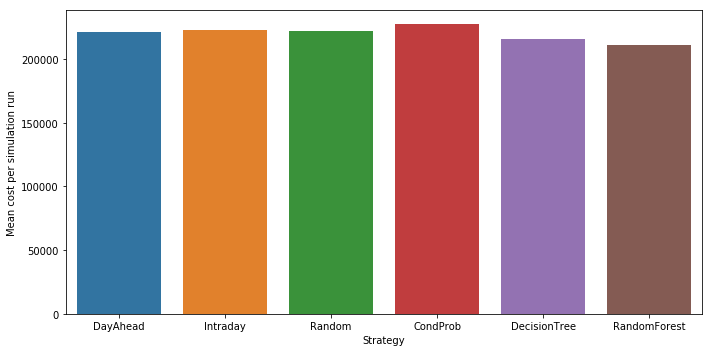

In [40]:
fig = plt.figure(figsize=(10,5))
sns.barplot(methodResults.columns.values, methodResults.mean())
plt.ylabel("Mean cost per simulation run")
plt.xlabel("Strategy")
plt.tight_layout()
plt.show();

    DayAhead   Intraday     Random   CondProb  DecisionTree  RandomForest
0  221509.19  222459.83  222396.01  226934.06     215311.35     211133.47
1  220487.82  221750.19  220696.04  226511.52     215008.02     209831.56
2  223176.03  224705.81  224574.92  229020.42     216893.27     212825.27
3  222030.08  223604.39  222964.19  227812.64     216567.64     211424.47


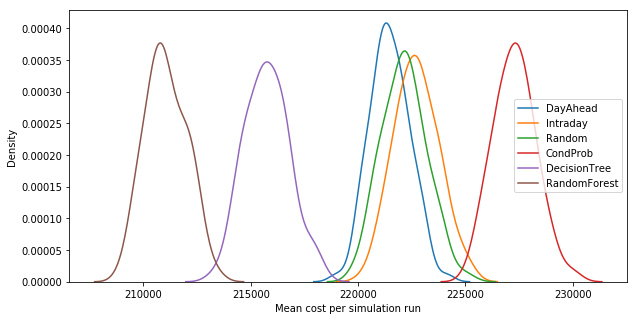

In [36]:
fig = plt.figure(figsize=(10,5))
print(methodResults.head(4))
for m in range(len(methods)):
    sns.kdeplot(methodResults.loc[:,methods[m]])
plt.xlabel("Mean cost per simulation run")
plt.ylabel("Density")
plt.show();
fig.savefig('Simulation results.png')

In [ ]:
print("F-Test to determine if methods produce costs of same distribution")
stat, p = f_oneway(methodResults["DayAhead"], methodResults["Intraday"], methodResults["Random"], methodResults["Regression"], methodResults["CondProb"], methodResults["RandomForest"])
print(stat)
print(p)
print("t-Test for Significance of difference between Day-ahead and regression")
print(stats.ttest_ind(methodResults["DayAhead"], methodResults["Regression"]))